# Master jupyter notebook for LANL - SlimBros Team

In [17]:
#dill.dump_session('notebook_env.db')
dill.load_session('notebook_env.db')

## Preliminaries
Let's import everything we need:

In [2]:
import os
import gc
import eli5
import csv
import dill
import time
import json
import random
import datetime
import warnings
import feather

import numpy as np
import pandas as pd
import altair as alt
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import HTML
from tqdm import tqdm_notebook
from altair.vega import v3
from catboost import CatBoostRegressor
from sklearn import svm, neighbors, linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GridSearchCV, cross_val_score, ParameterGrid, train_test_split
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
from utils import generate_segment_start_ids, compare_methods
from features import gpi, create_all_features_extended
from features import gpi_new, gpii_new, gpiii_new

from hyperparam_search import quick_hyperopt

#Configure the environment
%matplotlib inline
pd.options.display.precision = 17
warnings.filterwarnings('ignore')

GLOBAL_SEED = 42
BAGGING_SEED = 11

In [3]:
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))

Load/compute the necessary features

In [3]:
compute_features = False 
# The computed features are saved in an hdf file along with the time_to_failure to 
# save the time spend reading the training data and the feature computation
#train_data_format = 'csv'
train_data_format = 'feather'

## Training data

In [4]:
def load_train_data(file_format):
    """Loads the training dataset."""
    print(f'Loading data from {file_format} file:', end="")
    if file_format.lower() == 'feather':
        train_df = feather.read_dataframe('../input/train.feather')
    else:
        train_df = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16,
                                                            'time_to_failure': np.float32})
        feather.write_dataframe(train_df, '../input/train.feather')
    print("Done")
    return train_df

In [5]:
train = load_train_data(train_data_format)

Loading data from feather file:Done


In [6]:
time_to_failure_delta = np.diff(train['time_to_failure'])
init_times = np.where(time_to_failure_delta > 5)[0].tolist()
print(f'There are {len(init_times)} quakes on the training set.')

There are 16 quakes on the training set.


## Feature generation
- Usual aggregations: mean, std, min and max;
- Average difference between the consequitive values in absolute and percent values;
- Absolute min and max vallues;
- Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
- Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
- Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
- Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
- Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [7]:
#features_version = ''
#features_version = 'v2'
features_version = 'v3'

In [8]:
saved_files_present = (os.path.isfile(f'../tmp_results/X{features_version}_tr.hdf') and 
                       os.path.isfile(f'../tmp_results/X{features_version}_test.hdf') and 
                       os.path.isfile(f'../tmp_results/y{features_version}_tr.hdf') )

In [9]:
if saved_files_present:
    print(f'The files containing the features ({features_version}) already exist.')
else:
    print(f'The files containing the features ({features_version}) do not exist')
    print(f'In the following step, the features will be computed. This may take several hours.')

The files containing the features (v3) already exist.


In [10]:
if (not compute_features) and saved_files_present:
    print(f'Reading hdf files ({features_version}): ', end="")
    X_tr = pd.read_hdf(f'../tmp_results/X{features_version}_tr.hdf', 'data')
    X_test = pd.read_hdf(f'../tmp_results/X{features_version}_test.hdf', 'data')
    y_tr = pd.read_hdf(f'../tmp_results/y{features_version}_tr.hdf', 'data')  
    print("Done")
else:
    fs = 4000000 #Sampling frequency of the raw signal

    #Compute features for the training data
    segment_size = 150000
    segment_start_ids = generate_segment_start_ids('uniform_no_jump', segment_size, train)
    X_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64)
    y_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64, columns=['time_to_failure'])
    for idx in tqdm_notebook(range(len(segment_start_ids))):        
        seg_id = segment_start_ids[idx]
        seg = train.iloc[seg_id:seg_id + segment_size]
        create_all_features_extended(idx, seg, X_tr, fs)
        y_tr.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    # Sanity check
    means_dict = {}
    for col in X_tr.columns:
        if X_tr[col].isnull().any():
            print(col)
            mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
            X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
            X_tr[col] = X_tr[col].fillna(mean_value)
            means_dict[col] = mean_value

    #Compute features for the test data
    submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
    X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
    for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
        seg = pd.read_csv('../input/test/' + seg_id + '.csv')
        create_all_features_extended(seg_id, seg, X_test, fs)

    # Sanity check
    for col in X_test.columns:
        if X_test[col].isnull().any():
            X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
            X_test[col] = X_test[col].fillna(means_dict[col])
            
    X_tr.to_hdf(f'../tmp_results/X{features_version}_tr.hdf', 'data')
    X_test.to_hdf(f'../tmp_results/X{features_version}_test.hdf', 'data')
    y_tr.to_hdf(f'../tmp_results/y{features_version}_tr.hdf', 'data')
    
    del segment_start_ids
    del means_dict
    del submission
    
    print("Done")

Reading hdf files (v3): Done


## Scale data

In [11]:
alldata = pd.concat([X_tr, X_test])
scaler = StandardScaler()
alldata = pd.DataFrame(scaler.fit_transform(alldata), columns=alldata.columns)
X_train_scaled = alldata[:X_tr.shape[0]]
X_test_scaled = alldata[X_tr.shape[0]:]

## Building models

In [101]:
def train_model(X, X_test, y, folds, params=None, model_type='lgb',
                model=None, show_scatter=False, force_positive=False,
                compute_feature_importance=True):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    errors = []
    n_fold = folds.get_n_splits()
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())

        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
           
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric='mae',
                      verbose=0,
                      early_stopping_rounds=100)
            
            y_pred_valid = model.predict(X_valid)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        if model_type == 'lgb2':
            y_train = np.sqrt(y_train)
            y_valid = np.sqrt(y_valid)

            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric='mse',
                      verbose=0,
                      early_stopping_rounds=100)
            
            y_pred_valid = model.predict(X_valid)**2
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)**2

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data,
                              num_boost_round=20000,
                              evals=watchlist,
                              early_stopping_rounds=100,
                              verbose_eval=0,
                              params=params)

            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns),
                                   ntree_limit=model.best_ntree_limit)

        if model_type == 'xgb2':
            y_train = np.sqrt(y_train)
            y_valid = np.sqrt(y_valid)

            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data,
                              num_boost_round=20000,
                              evals=watchlist,
                              early_stopping_rounds=100,
                              verbose_eval=0,
                              params=params)

            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)**2
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns),
                                   ntree_limit=model.best_ntree_limit)**2
            
        if model_type == 'gpi':
            y_pred_valid = gpi(X_valid, activation=params['activation']).values
            y_pred = gpi(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)

        if model_type == 'gpi_new':
            y_pred_valid = gpi_new(X_valid, activation=params['activation']).values
            y_pred = gpi_new(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
            
        if model_type == 'gpii_new':
            y_pred_valid = gpii_new(X_valid, activation=params['activation']).values
            y_pred = gpii_new(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
        if model_type == 'gpiii_new':
            y_pred_valid = gpiii_new(X_valid, activation=params['activation']).values
            y_pred = gpiii_new(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        if type(X) == np.ndarray:
            errors.append(y_valid-y_pred_valid)
        else:
            errors.append(y_valid['time_to_failure'].values-y_pred_valid)

        
        prediction += y_pred    
        
        if (model_type == 'lgb' or model_type == 'lgb2') and compute_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = X.columns
            fold_importance['importance'] = model.feature_importances_
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    errors = [y for x in errors for y in x]
    
    if force_positive:
        prediction = prediction.clip(min=0)    
    
    if show_scatter:
        fig, axis = plt.subplots(1, 3, figsize=(15,5))
        ax1, ax2, ax3 = axis
        
        ax1.scatter(y, oof, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
        ax1.set_xlabel('actual')
        ax1.set_ylabel('predicted')

        ax2.plot(y, color='blue', label='y_train')
        ax2.plot(oof, color='orange')
        ax2.plot(y, color='blue', label='y_train')
        ax2.plot(oof, color='orange')
        ax2.set_xlabel('train index')
        ax2.set_ylabel('time to failure')

        ax3.hist(errors, bins='auto', alpha=0.5, density=True)
        ax3.set_xlabel('error')
        ax3.set_ylabel('count')
        ax3.set_xlim(-10, 10)

    print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    
    if (model_type == 'lgb' or model_type == 'lgb2') and compute_feature_importance:
        feature_importance['importance'] /= n_fold
        return oof, prediction, scores, feature_importance
    else:
        return oof, prediction, scores

In [13]:
n_fold = 5
folds_models = KFold(n_splits=n_fold, shuffle=True, random_state=GLOBAL_SEED)

Let's try a few different models and submit the one with the best validation score. The predicted values in the following plots are using a out-of-fold scheme.

### LGBM (Gradient Boosting)

Fold 0 started at Sat Jun  1 09:12:11 2019
Fold 1 started at Sat Jun  1 09:13:05 2019
Fold 2 started at Sat Jun  1 09:14:04 2019
Fold 3 started at Sat Jun  1 09:14:35 2019
Fold 4 started at Sat Jun  1 09:15:15 2019
CV mean score: 2.0104, std: 0.0332.


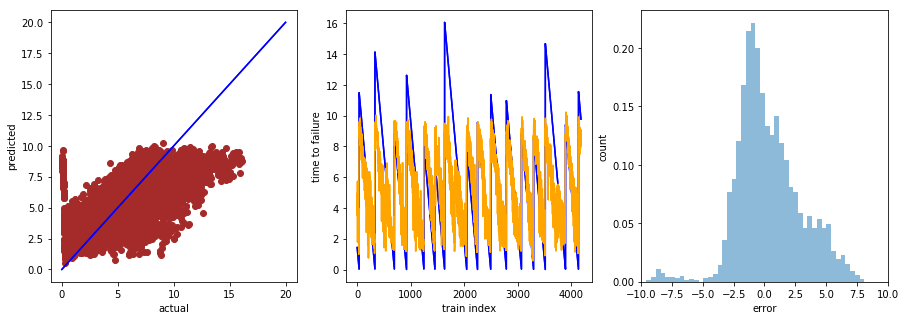

In [14]:
#TODO: optimize params
params_lgb = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': BAGGING_SEED,
    'random_seed': GLOBAL_SEED,
    'metric': 'mae',
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}
oof_lgb, prediction_lgb, scores_lgb, feature_importance_lgb = train_model(X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=True)

In [15]:
#params_lgb_opt = quick_hyperopt(X_train_scaled, y_tr, num_evals=100, eval_metric='mae')

In [16]:
#oof_lgb_opt, prediction_lgb_opt, scores_lgb_opt, feature_importance_lgb_opt = train_model(X=X_train_scaled,
#                                                                          X_test=X_test_scaled,
#                                                                          y=y_tr,
#                                                                          folds=folds_models,
#                                                                          params=params_lgb_opt,
#                                                                          model_type='lgb',
#                                                                          show_scatter=True)

Fold 0 started at Sat Jun  1 09:15:52 2019
Fold 1 started at Sat Jun  1 09:16:18 2019
Fold 2 started at Sat Jun  1 09:16:43 2019
Fold 3 started at Sat Jun  1 09:17:01 2019
Fold 4 started at Sat Jun  1 09:17:18 2019
CV mean score: 3.1949, std: 0.0935.


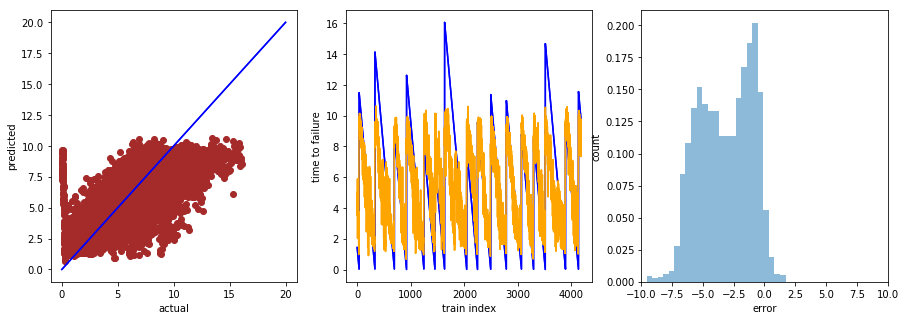

In [17]:
params_lgb2 = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': BAGGING_SEED,
    'random_seed': GLOBAL_SEED,
    'metric': 'mse',
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}
oof_lgb2, prediction_lgb2, scores_lgb2, feature_importance_lgb2 = train_model(X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_models,
    params=params_lgb2,
    model_type='lgb2',
    show_scatter=True)

### XGBoost (Gradient Boosting)

Fold 0 started at Sat Jun  1 09:17:38 2019
Fold 1 started at Sat Jun  1 09:17:49 2019
Fold 2 started at Sat Jun  1 09:18:03 2019
Fold 3 started at Sat Jun  1 09:18:11 2019
Fold 4 started at Sat Jun  1 09:18:20 2019
CV mean score: 2.0089, std: 0.0324.


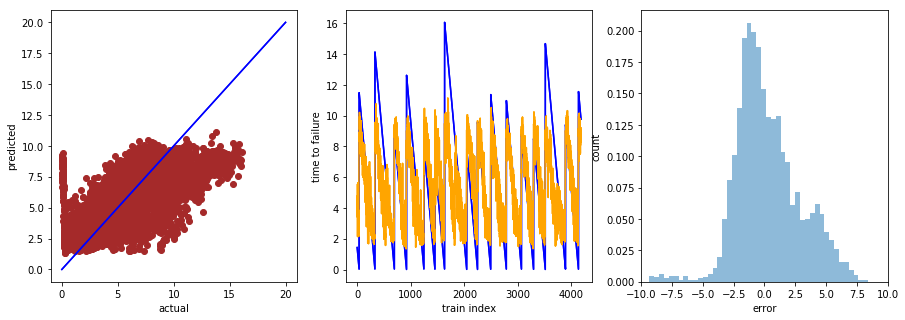

In [18]:
#TODO: optimize params
params_xgb = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
}
oof_xgb, prediction_xgb, scores_xgb = train_model(X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_models,
    params=params_xgb,
    model_type='xgb',
    show_scatter=True)

Fold 0 started at Sat Jun  1 09:18:31 2019
Fold 1 started at Sat Jun  1 09:18:47 2019
Fold 2 started at Sat Jun  1 09:19:02 2019
Fold 3 started at Sat Jun  1 09:19:15 2019
Fold 4 started at Sat Jun  1 09:19:29 2019
CV mean score: 3.0189, std: 0.0846.


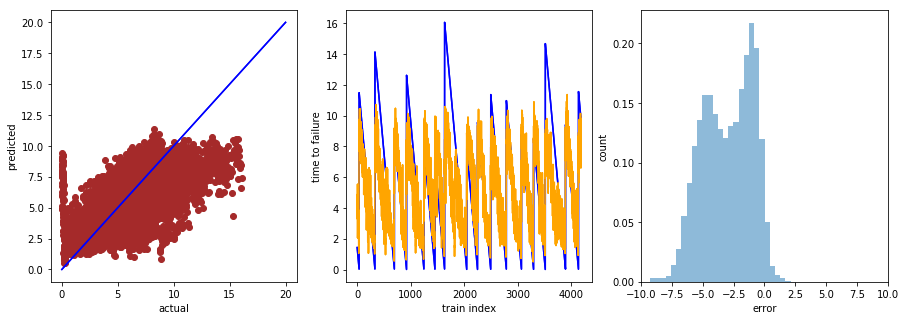

In [19]:
#TODO: optimize params
params_xgb2 = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': True,
    'nthread': 32
}
oof_xgb2, prediction_xgb2, scores_xgb2 = train_model(X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_models,
    params=params_xgb2,
    model_type='xgb2',
    show_scatter=True)

### Magic model (from Kaggle)

In [20]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/magic_submission.csv', index_col='seg_id')
prediction_magic = submission['time_to_failure']
submission.to_csv('../output/submission_magic.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.19883099684182648
seg_0012b5,4.94642502508022641
seg_00184e,5.04955863803668947
seg_003339,8.62528338277710738
seg_0042cc,7.21933832205638293


### Neural network (LSTM)

In [21]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/submission_lstm.csv', index_col='seg_id')
prediction_lstm = submission['time_to_failure']
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.49480199999999996
seg_0012b5,6.37969450000000027
seg_00184e,3.46450879999999950
seg_003339,9.29934399999999961
seg_0042cc,6.78247400000000056


In [84]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/submission_lstm_fold1.csv', index_col='seg_id')
prediction_lstm_fold1 = submission['time_to_failure']
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/submission_lstm_fold2.csv', index_col='seg_id')
prediction_lstm_fold2 = submission['time_to_failure']
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/submission_lstm_fold3.csv', index_col='seg_id')
prediction_lstm_fold3 = submission['time_to_failure']
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/submission_lstm_fold4.csv', index_col='seg_id')
prediction_lstm_fold4 = submission['time_to_failure']
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/submission_lstm_fold5.csv', index_col='seg_id')
prediction_lstm_fold5 = submission['time_to_failure']
prediction_lstm_5fold = (prediction_lstm_fold1 + prediction_lstm_fold2 + prediction_lstm_fold3
                                + prediction_lstm_fold4 + prediction_lstm_fold5) / 5
submission['time_to_failure'] = prediction_lstm_5fold
submission.to_csv('../output/submission_lstm_5fold.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.01570074000000021
seg_0012b5,5.08500470000000071
seg_00184e,5.28868231999999949
seg_003339,8.47141685999999972
seg_0042cc,7.09280523999999968


In [23]:
lstm_mse = [0.4763612747192383, 0.5046306848526001, 0.48798587918281555, 0.4985106289386749, 0.46727022528648376]
scores_lstm = np.sqrt(lstm_mse)

### Genetic Program Models (borrowed from Kaggle)

Fold 0 started at Sat Jun  1 17:24:57 2019
Fold 1 started at Sat Jun  1 17:24:58 2019
Fold 2 started at Sat Jun  1 17:24:59 2019
Fold 3 started at Sat Jun  1 17:25:00 2019
Fold 4 started at Sat Jun  1 17:25:01 2019
CV mean score: 1.9140, std: 0.0328.
Fold 0 started at Sat Jun  1 17:25:01 2019
Fold 1 started at Sat Jun  1 17:25:02 2019
Fold 2 started at Sat Jun  1 17:25:03 2019
Fold 3 started at Sat Jun  1 17:25:03 2019
Fold 4 started at Sat Jun  1 17:25:04 2019
CV mean score: 1.9543, std: 0.0398.
Fold 0 started at Sat Jun  1 17:25:05 2019
Fold 1 started at Sat Jun  1 17:25:05 2019
Fold 2 started at Sat Jun  1 17:25:06 2019
Fold 3 started at Sat Jun  1 17:25:07 2019
Fold 4 started at Sat Jun  1 17:25:07 2019
CV mean score: 1.9698, std: 0.0356.
Fold 0 started at Sat Jun  1 17:25:08 2019
Fold 1 started at Sat Jun  1 17:25:09 2019
Fold 2 started at Sat Jun  1 17:25:09 2019
Fold 3 started at Sat Jun  1 17:25:10 2019
Fold 4 started at Sat Jun  1 17:25:11 2019
CV mean score: 1.9563, std: 0.03

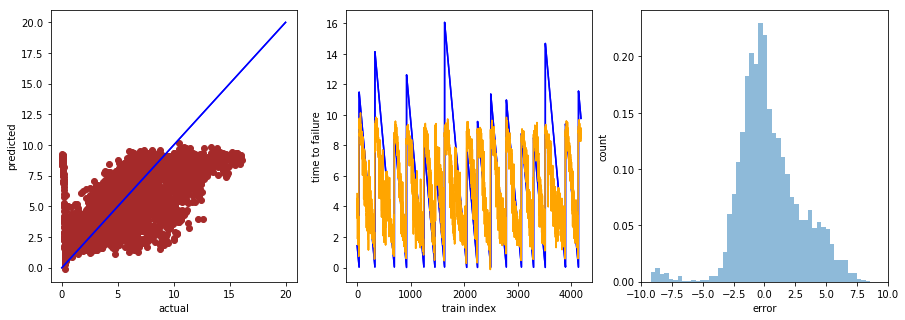

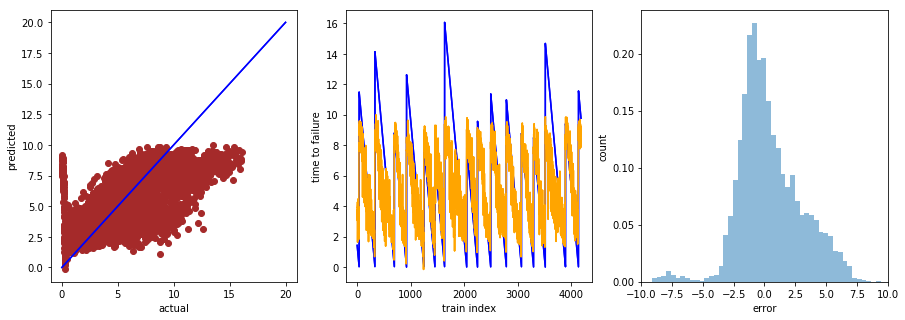

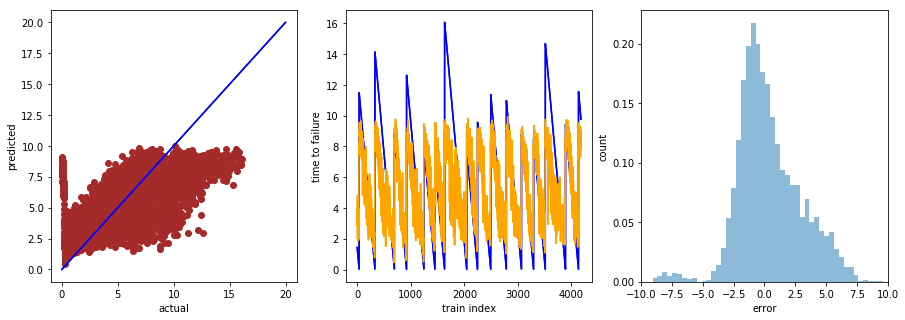

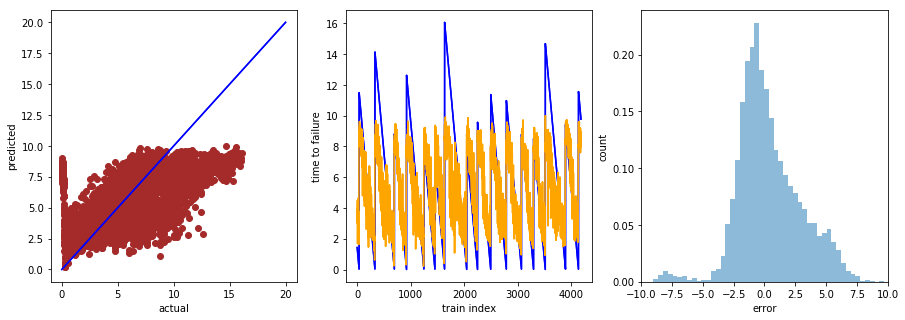

In [102]:
params_gpi = {
    'activation':'atan'
}
oof_gpi, prediction_gpi, scores_gpi = train_model(X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_models,
    params=params_gpi,
    model_type='gpi',
    show_scatter=True)

params_gpi_new = {
    'activation':'atan'
}
oof_gpi_new, prediction_gpi_new, scores_gpi_new = train_model(X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_models,
     params=params_gpi_new,
    model_type='gpi_new',
    show_scatter=True)

params_gpii_new = {
    'activation':'atan'
}
oof_gpii_new, prediction_gpii_new, scores_gpii_new = train_model(X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_models,
    params=params_gpii_new,
    model_type='gpii_new',
    show_scatter=True)

params_gpiii_new = {
    'activation':'atan'
}
oof_gpiii_new, prediction_gpiii_new, scores_gpiii_new = train_model(X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_models,
    params=params_gpiii_new,
    model_type='gpiii_new',
    show_scatter=True)

In [25]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_gpi
submission.to_csv('../output/submission_gpi_atan.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.23177648601559886
seg_0012b5,5.12426741617585879
seg_00184e,4.81572360824318402
seg_003339,8.03248539017365459
seg_0042cc,6.70281537269930983


In [26]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = (prediction_gpi + prediction_magic) / 2
submission.to_csv('../output/submission_magic_and_gpi.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.21530374142871267
seg_0012b5,5.03534622062804260
seg_00184e,4.93264112313993675
seg_003339,8.32888438647538010
seg_0042cc,6.96107684737784638


In [27]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = (prediction_lstm + prediction_gpi) / 2
submission.to_csv('../output/submission_gpi_and_lstm.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.86328924300779963
seg_0012b5,5.75198095808792953
seg_00184e,4.14011620412159154
seg_003339,8.66591469508682621
seg_0042cc,6.74264468634965475


# Compare models

LGB-opt not computed


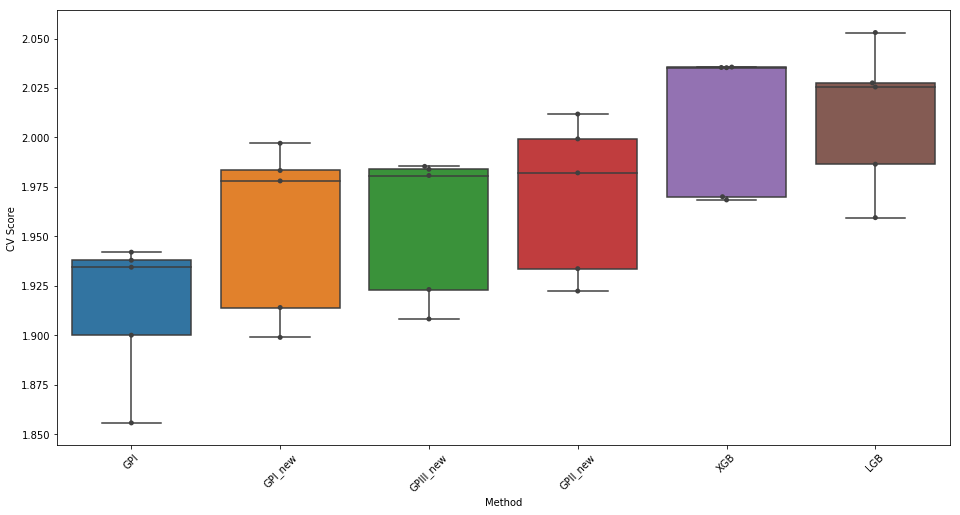

In [113]:
plt.figure(figsize=(16, 8));
scores_df = pd.DataFrame()

try:
    scores_df['LGB'] = scores_lgb
except NameError:
    print('LGB not computed')
try:
    scores_df['LGB-opt'] = scores_lgb_opt
except NameError:
    print('LGB-opt not computed')
try:
    scores_df['XGB'] = scores_xgb
except NameError:
    print('XGB not computed')
try:
    scores_df['GPI'] = scores_gpi
except NameError:
    print('GPI not computed')
try:
    scores_df['GPI_new'] = scores_gpi_new
except NameError:
    print('GPI_new not computed')
try:
    scores_df['GPII_new'] = scores_gpii_new
except NameError:
    print('GPII_new not computed')    
try:
    scores_df['GPIII_new'] = scores_gpiii_new
except NameError:
    print('GPIII_new not computed')     
#try:
    #scores_df['LSTM'] = scores_lstm
#except NameError:
#    print('LSTM not computed')     

ax = sns.boxplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1));
ax = sns.swarmplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1), color=".25")

plt.xticks(rotation=45);
plt.xlabel('Method');
plt.ylabel('CV Score');

## Feature reduction

### Dropping highly correlated features
Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

In [29]:
X_train_scaled_uncorr = X_train_scaled.copy()
X_test_scaled_uncorr = X_test_scaled.copy()
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X_train_scaled_uncorr.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X_train_scaled_uncorr = X_train_scaled_uncorr.drop(to_drop, axis=1)
X_test_scaled_uncorr = X_test_scaled_uncorr.drop(to_drop, axis=1)

Fold 0 started at Sat Jun  1 09:20:34 2019
Fold 1 started at Sat Jun  1 09:20:52 2019
Fold 2 started at Sat Jun  1 09:21:12 2019
Fold 3 started at Sat Jun  1 09:21:28 2019
Fold 4 started at Sat Jun  1 09:21:50 2019
CV mean score: 2.0187, std: 0.0380.


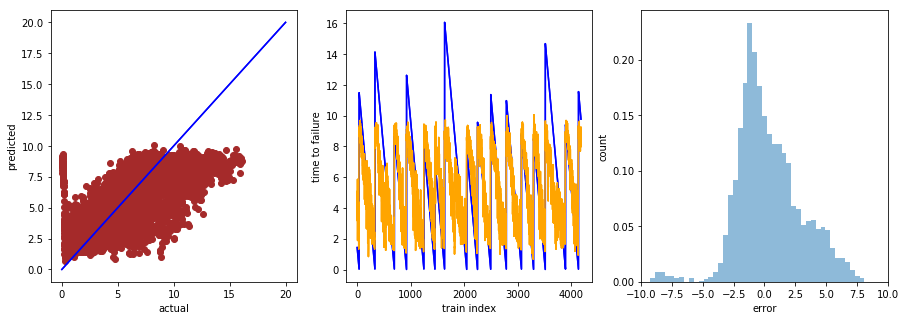

In [30]:
#TODO: Optimize
params_lgb_uncorr = {
    'bagging_fraction': 0.6,
    'bagging_freq': 4,
    'bagging_seed': BAGGING_SEED,
    'boosting': 'gbdt',
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775,
    'learning_rate': 0.005,
    'max_depth': 8,
    'metric': 'mae',
    'min_data_in_leaf': 40,
    'num_leaves': 12,    
    'objective': 'huber',
    'verbosity': -1,
    'random_seed': GLOBAL_SEED
}
oof_lgb_uncorr, prediction_lgb_uncorr, scores_lgb_uncorr = train_model(
    X=X_train_scaled_uncorr,
    X_test=X_test_scaled_uncorr,
    y=y_tr,
    folds=folds_models,
    params=params_lgb_uncorr,
    model_type='lgb',
    compute_feature_importance=False,
    show_scatter=True)

In [31]:
#params_lgb_uncorr_opt = quick_hyperopt(X_train_scaled_uncorr, y_tr, num_evals=100)

In [32]:
#oof_lgb_uncorr_opt, prediction_lgb_uncorr_opt, scores_lgb_uncorr_opt = train_model(
#    X=X_train_scaled_uncorr,
#    X_test=X_test_scaled_uncorr,
#    y=y_tr,
#    folds=folds_models,
#    params=params_lgb_uncorr_opt,
#    model_type='lgb',
#    compute_feature_importance=False,
#    show_scatter=True)

Fold 0 started at Sat Jun  1 17:35:40 2019
Fold 1 started at Sat Jun  1 17:35:45 2019
Fold 2 started at Sat Jun  1 17:35:50 2019
Fold 3 started at Sat Jun  1 17:35:55 2019
Fold 4 started at Sat Jun  1 17:35:59 2019
CV mean score: 2.0215, std: 0.0294.


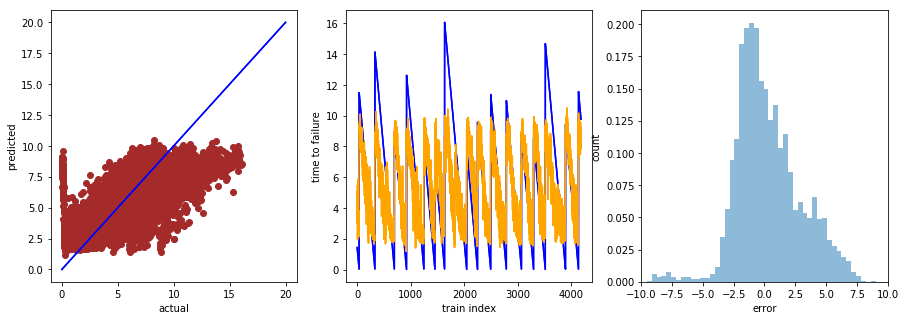

In [114]:
#TODO: optimize params
params_xgb_uncorr = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
}
oof_xgb_uncorr, prediction_xgb_uncorr, scores_xgb_uncorr = train_model(
    X=X_train_scaled_uncorr,
    X_test=X_test_scaled_uncorr,
    y=y_tr,
    folds=folds_models,
    params=params_xgb_uncorr,
    model_type='xgb',
    show_scatter=True)

### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

In [33]:
recompute_eli5 = False

In [34]:
params_lgb = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': BAGGING_SEED,
    'random_seed': GLOBAL_SEED,
    'metric': 'mae',
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}
if recompute_eli5:
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled, y_tr, test_size=0.2)
    model = lgb.LGBMRegressor(**params_lgb, n_estimators = 50000, n_jobs = -1, verbose=-1)
    model.fit(X_train,
              y_train, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric='mae',
              verbose=10000,
              early_stopping_rounds=200)
    perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
    #eli5.show_weights(perm, top=200, feature_names=X_train_scaled.columns.values.tolist())
    top_num_features = 150
    top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:top_num_features]

    top_features_df = pd.DataFrame(data=top_features)
    top_features_df.columns = ['top_features']
    top_features_df.to_csv(f'../tmp_results/top_features_eli5.csv', index=False)
else:
    top_features = pd.read_csv(f'../tmp_results/top_features_eli5.csv')['top_features'].to_list()

Fold 0 started at Sat Jun  1 09:22:06 2019
Fold 1 started at Sat Jun  1 09:22:13 2019
Fold 2 started at Sat Jun  1 09:22:20 2019
Fold 3 started at Sat Jun  1 09:22:24 2019
Fold 4 started at Sat Jun  1 09:22:30 2019
CV mean score: 1.9641, std: 0.0395.


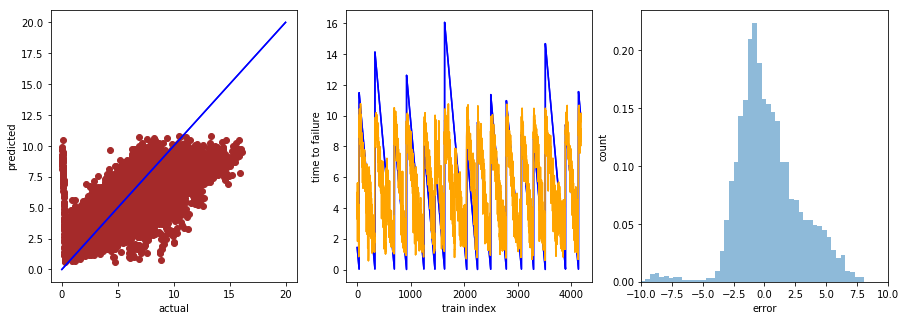

In [35]:
params_lgb = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': BAGGING_SEED,
    'random_seed': GLOBAL_SEED,
    'metric': 'mae',
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}
oof_lgb_eli5_top, prediction_lgb_eli5_top, scores_lgb_eli5_top = train_model(
    X=X_train_scaled[top_features],
    X_test=X_test_scaled[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    compute_feature_importance=False,
    show_scatter=True)

In [36]:
#params_lgb_opt = quick_hyperopt(X_train_scaled[top_features], y_tr, num_evals=100)

In [37]:
#oof_lgb_eli5_top_opt, prediction_lgb_eli5_top_opt, scores_lgb_eli5_top_opt = train_model(
#    X=X_train_scaled[top_features],
#    X_test=X_test_scaled[top_features],
#    y=y_tr,
#    folds=folds_models,
#    params=params_lgb_opt,
#    model_type='lgb',
#    compute_feature_importance=False,
#    show_scatter=True)

Fold 0 started at Sun Jun  2 20:16:55 2019
Fold 1 started at Sun Jun  2 20:16:56 2019
Fold 2 started at Sun Jun  2 20:16:58 2019
Fold 3 started at Sun Jun  2 20:16:59 2019
Fold 4 started at Sun Jun  2 20:17:00 2019
CV mean score: 1.9832, std: 0.0326.


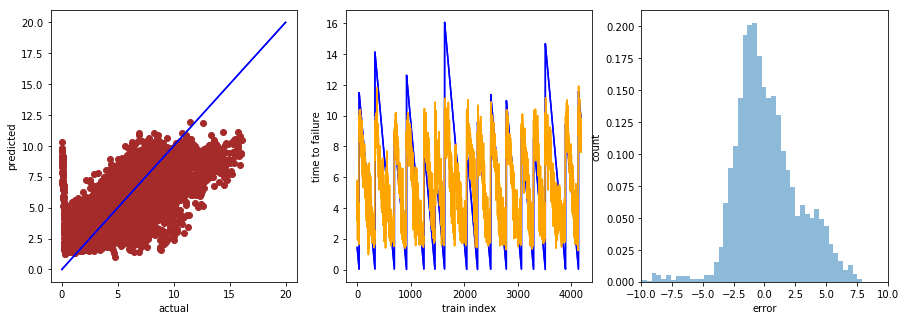

In [8]:
#TODO: optimize params
params_xgb = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
}
oof_xgb_eli5_top, prediction_xgb_eli5_top, scores_xgb_eli5_top = train_model(
    X=X_train_scaled[top_features],
    X_test=X_test_scaled[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_xgb,
    model_type='xgb',
    show_scatter=True)

Fold 0 started at Sat Jun  1 09:22:35 2019
Fold 1 started at Sat Jun  1 09:22:38 2019
Fold 2 started at Sat Jun  1 09:22:40 2019
Fold 3 started at Sat Jun  1 09:22:41 2019
Fold 4 started at Sat Jun  1 09:22:43 2019
CV mean score: 3.2130, std: 0.1110.


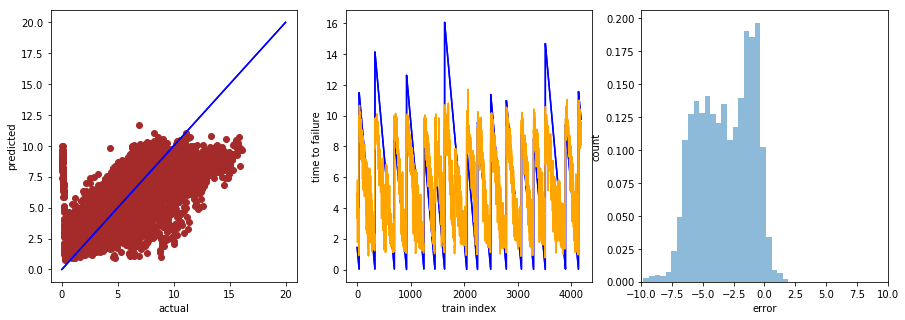

In [38]:
params_lgb2 = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': BAGGING_SEED,
    'random_seed': GLOBAL_SEED,
    'metric': 'mae', # WARNING!!!!!! THIS SHOULD BE DIFFERENT. RESULTS NOT APPLICABLE
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}
oof_lgb2_eli5_top, prediction_lgb2_eli5_top, scores_lgb2_eli5_top = train_model(
    X=X_train_scaled[top_features],
    X_test=X_test_scaled[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb2,
    model_type='lgb2',
    compute_feature_importance=False,
    show_scatter=True)

In [39]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb2_eli5_top
submission.to_csv('../output/submission_lgb_eli5_top_mse.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.63274163872058464
seg_0012b5,5.54554474524309171
seg_00184e,5.52072060713397317
seg_003339,8.57303922706831933
seg_0042cc,7.05058189130080848


Fold 0 started at Sat Jun  1 09:22:45 2019
Fold 1 started at Sat Jun  1 09:22:48 2019
Fold 2 started at Sat Jun  1 09:22:50 2019
Fold 3 started at Sat Jun  1 09:22:52 2019
Fold 4 started at Sat Jun  1 09:22:54 2019
CV mean score: 3.2145, std: 0.1140.


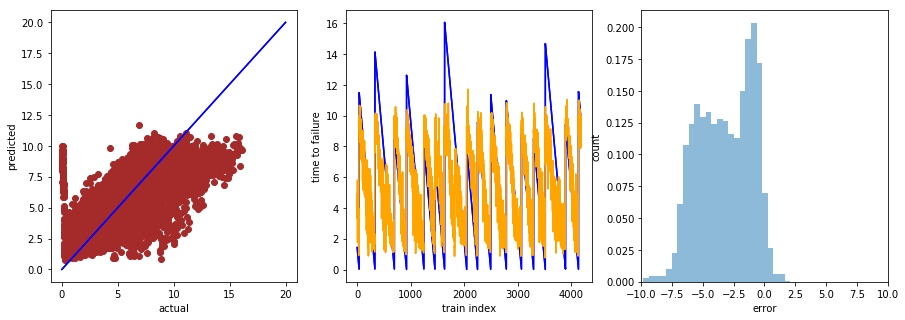

In [40]:
params_lgb2 = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': BAGGING_SEED,
    'random_seed': GLOBAL_SEED,
    'metric': 'mse', # WARNING!!!!!! THIS SHOULD BE DIFFERENT. RESULTS NOT APPLICABLE
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}
oof_lgb2_eli5_top_mse, prediction_lgb2_eli5_top_mse, scores_lgb2_eli5_top_mse = train_model(
    X=X_train_scaled[top_features],
    X_test=X_test_scaled[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb2,
    model_type='lgb2',
    compute_feature_importance=False,
    show_scatter=True)

In [41]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb2_eli5_top_mse
submission.to_csv('../output/submission_lgb_eli5_top_mse.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.58832462870779745
seg_0012b5,5.53685107536233634
seg_00184e,5.51989559470570601
seg_003339,8.57925886035446794
seg_0042cc,7.04163445543433664


Fold 0 started at Sat Jun  1 09:22:56 2019
Fold 1 started at Sat Jun  1 09:22:59 2019
Fold 2 started at Sat Jun  1 09:23:02 2019
Fold 3 started at Sat Jun  1 09:23:03 2019
Fold 4 started at Sat Jun  1 09:23:06 2019
CV mean score: 3.0819, std: 0.1142.


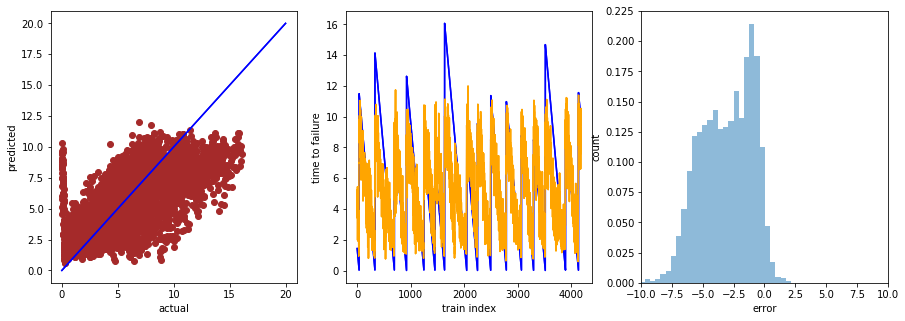

In [42]:
#TODO: optimize params
params_xgb2 = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': True,
    'nthread': 32
}
oof_xgb2_eli5_top, prediction_xgb2_eli5_top, scores_xgb2_eli5_top = train_model(X=X_train_scaled[top_features],
  X_test=X_test_scaled[top_features],
  y=y_tr,
  folds=folds_models,
  params=params_xgb2,
  model_type='xgb2',
  show_scatter=True)

In [43]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_xgb2_eli5_top
submission.to_csv('../output/submission_xgb_eli5_top_rmse.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.29585185050964347
seg_0012b5,5.39692764282226545
seg_00184e,5.35856990814208967
seg_003339,8.47425107955932688
seg_0042cc,7.03601217269897461


In [44]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = (prediction_xgb2_eli5_top + prediction_magic) / 2
submission.to_csv('../output/submission_magic_xgb_eli5_top_rmse.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.74734142367573497
seg_0012b5,5.17167633395124593
seg_00184e,5.20406427308939001
seg_003339,8.54976723116821802
seg_0042cc,7.12767524737767921


In [45]:
recompute_eli5_uncorr = False

In [46]:
params_lgb_uncorr = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': BAGGING_SEED,
    'random_seed': GLOBAL_SEED,
    'metric': 'mae',
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}
if recompute_eli5_uncorr:
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled_uncorr, y_tr, test_size=0.2)
    model = lgb.LGBMRegressor(**params_lgb_uncorr, n_estimators = 50000, n_jobs = -1, verbose=-1)
    model.fit(X_train,
              y_train, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric='mae',
              verbose=10000,
              early_stopping_rounds=200)
    perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
    #eli5.show_weights(perm, top=200, feature_names=X_train_scaled.columns.values.tolist())
    top_uncorr_num_features = 150
    top_uncorr_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:top_uncorr_num_features]

    top_features_df = pd.DataFrame(data=top_uncorr_features)
    top_features_df.columns = ['top_features']
    top_features_df.to_csv(f'../tmp_results/top_features_eli5_uncorr.csv', index=False)
else:
    top_uncorr_features = pd.read_csv(f'../tmp_results/top_features_eli5_uncorr.csv')['top_features'].to_list()

Fold 0 started at Sat Jun  1 09:23:09 2019
Fold 1 started at Sat Jun  1 09:23:13 2019
Fold 2 started at Sat Jun  1 09:23:18 2019
Fold 3 started at Sat Jun  1 09:23:22 2019
Fold 4 started at Sat Jun  1 09:23:28 2019
CV mean score: 1.9805, std: 0.0399.


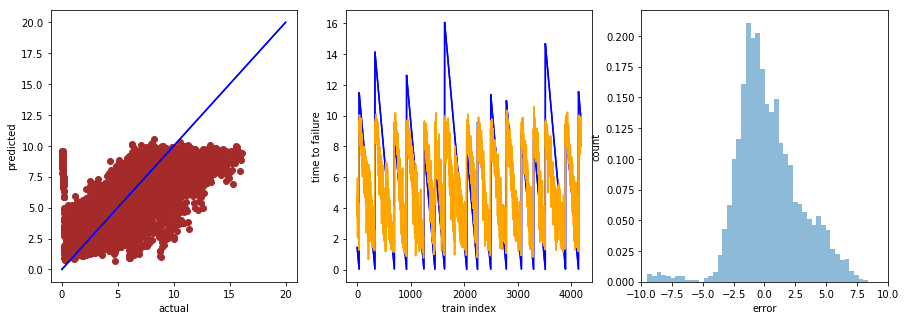

In [47]:
oof_lgb_eli5_uncorr_top, prediction_lgb_eli5_uncorr_top, scores_lgb_eli5_uncorr_top = train_model(
    X=X_train_scaled_uncorr[top_uncorr_features],
    X_test=X_test_scaled_uncorr[top_uncorr_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb_uncorr,
    model_type='lgb',
    compute_feature_importance=False,
    show_scatter=True)

In [48]:
#params_lgb_uncorr_opt = quick_hyperopt(X_train_scaled_uncorr[top_features], y_tr, num_evals=100)

In [49]:
#oof_lgb_eli5_uncorr_top_opt, prediction_lgb_eli5_uncorr_top_opt, scores_lgb_eli5_uncorr_top_opt = train_model(
#    X=X_train_scaled_uncorr[top_features],
#    X_test=X_test_scaled_uncorr[top_features],
#    y=y_tr,
#    folds=folds_models,
#    params=params_lgb_uncorr_opt,
#    model_type='lgb',
#    compute_feature_importance=False,
#    show_scatter=True)

Fold 0 started at Sat Jun  1 09:23:33 2019
Fold 1 started at Sat Jun  1 09:23:36 2019
Fold 2 started at Sat Jun  1 09:23:37 2019
Fold 3 started at Sat Jun  1 09:23:39 2019
Fold 4 started at Sat Jun  1 09:23:40 2019
CV mean score: 3.1923, std: 0.0845.


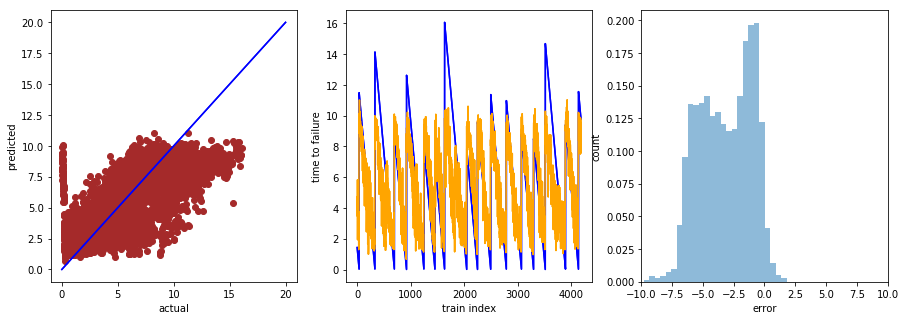

In [50]:
params_lgb2 = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': BAGGING_SEED,
    'random_seed': GLOBAL_SEED,
    'metric': 'mae',
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}
oof_lgb2_eli5_uncorr_top, prediction_lgb2_eli5_uncorr_top, scores_lgb2_eli5_uncorr_top = train_model(
    X=X_train_scaled[top_uncorr_features],
    X_test=X_test_scaled[top_uncorr_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb2,
    model_type='lgb2',
    compute_feature_importance=False,
    show_scatter=True)

In [51]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb2_eli5_uncorr_top
submission.to_csv('../output/submission_2.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.94012973811562173
seg_0012b5,5.43671593793389274
seg_00184e,5.79800658268363023
seg_003339,8.68224175140492171
seg_0042cc,7.09472268177603915


In [52]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = (prediction_lgb2_eli5_uncorr_top + prediction_magic) / 2
submission.to_csv('../output/submission_magic_and_lgb_eli5_top.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.06948036747872433
seg_0012b5,5.19157048150705958
seg_00184e,5.42378261036015985
seg_003339,8.65376256709101455
seg_0042cc,7.15703050191621060


Fold 0 started at Sun Jun  2 21:45:20 2019
Fold 1 started at Sun Jun  2 21:45:26 2019
Fold 2 started at Sun Jun  2 21:45:33 2019
Fold 3 started at Sun Jun  2 21:45:38 2019
Fold 4 started at Sun Jun  2 21:45:43 2019
CV mean score: 1.9761, std: 0.0182.


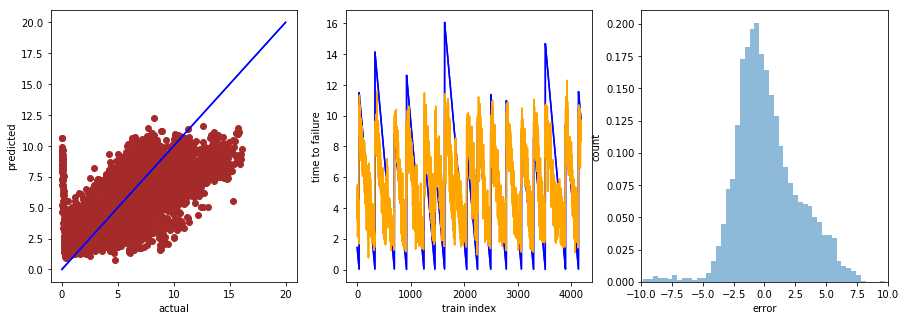

In [18]:
#TODO!!!!!: optimize params
params_xgb_uncorr = {
    'eta': 0.01,
    'max_depth': 100,#6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
}
oof_xgb_eli5_uncorr_top, prediction_xgb_eli5_uncorr_top, scores_xgb_eli5_uncorr_top = train_model(
    X=X_train_scaled_uncorr[top_uncorr_features],
    X_test=X_test_scaled_uncorr[top_uncorr_features],
    y=y_tr,
    folds=folds_models,
    params=params_xgb_uncorr,
    model_type='xgb',
    show_scatter=True)

Fold 0 started at Sun Jun  2 20:41:29 2019
Fold 1 started at Sun Jun  2 20:41:31 2019
Fold 2 started at Sun Jun  2 20:41:32 2019
Fold 3 started at Sun Jun  2 20:41:33 2019
Fold 4 started at Sun Jun  2 20:41:33 2019
CV mean score: 2.0277, std: 0.0159.
Fold 0 started at Sun Jun  2 20:41:34 2019
Fold 1 started at Sun Jun  2 20:41:35 2019
Fold 2 started at Sun Jun  2 20:41:38 2019
Fold 3 started at Sun Jun  2 20:41:38 2019
Fold 4 started at Sun Jun  2 20:41:39 2019
CV mean score: 1.9964, std: 0.0207.
Fold 0 started at Sun Jun  2 20:41:40 2019
Fold 1 started at Sun Jun  2 20:41:42 2019
Fold 2 started at Sun Jun  2 20:41:44 2019
Fold 3 started at Sun Jun  2 20:41:46 2019
Fold 4 started at Sun Jun  2 20:41:47 2019
CV mean score: 1.9795, std: 0.0258.
Fold 0 started at Sun Jun  2 20:41:49 2019
Fold 1 started at Sun Jun  2 20:41:54 2019
Fold 2 started at Sun Jun  2 20:41:58 2019
Fold 3 started at Sun Jun  2 20:42:02 2019
Fold 4 started at Sun Jun  2 20:42:05 2019
CV mean score: 1.9782, std: 0.02

Text(0, 0.5, 'scores_std')

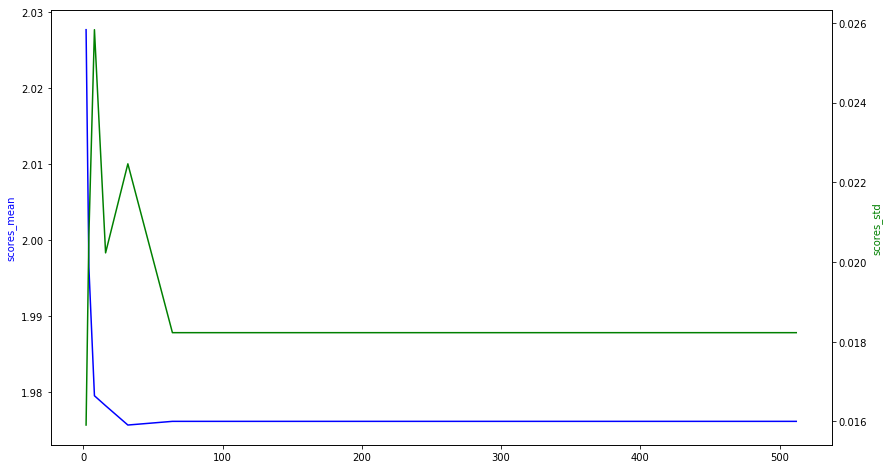

In [15]:
depths = [2, 4, 8, 16, 32, 64, 128, 256, 512]
scores_mean = []
scores_std = []
for depth in depths:
    params_xgb_uncorr = {
    'eta': 0.01,
    'max_depth': depth,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
    }
    oof_xgb_eli5_uncorr_top, prediction_xgb_eli5_uncorr_top, scores_xgb_eli5_uncorr_top = train_model(
        X=X_train_scaled_uncorr[top_uncorr_features],
        X_test=X_test_scaled_uncorr[top_uncorr_features],
        y=y_tr,
        folds=folds_models,
        params=params_xgb_uncorr,
        model_type='xgb',
        show_scatter=False)
    scores_mean.append(np.mean(scores_xgb_eli5_uncorr_top))
    scores_std.append(np.std(scores_xgb_eli5_uncorr_top))

fig, ax1 = plt.subplots(figsize=(14, 8))
plt.plot(depths, scores_mean, color='b')
ax1.set_ylabel('scores_mean', color='b')
ax2 = ax1.twinx()
plt.plot(depths, scores_std, color='g')
ax2.set_ylabel('scores_std', color='g')

Fold 0 started at Sat Jun  1 09:23:42 2019
Fold 1 started at Sat Jun  1 09:23:44 2019
Fold 2 started at Sat Jun  1 09:23:46 2019
Fold 3 started at Sat Jun  1 09:23:48 2019
Fold 4 started at Sat Jun  1 09:23:50 2019
CV mean score: 3.0427, std: 0.1255.


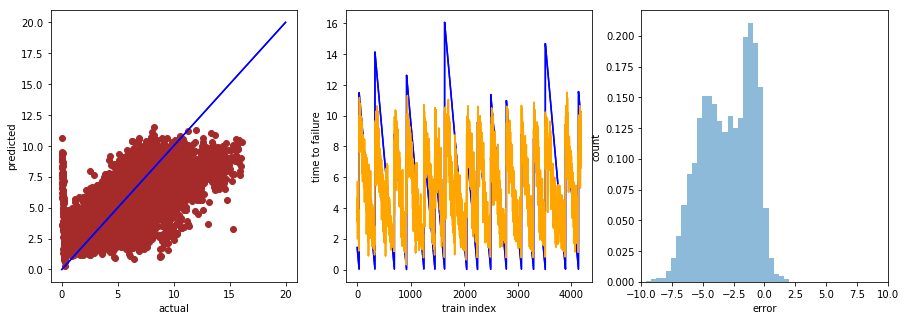

In [53]:
#TODO: optimize params
params_xgb2 = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': True,
    'nthread': 32
}
oof_xgb2_eli5_uncorr_top, prediction_xgb2_eli5_uncorr_top, scores_xgb2_eli5_uncorr_top = train_model(
    X=X_train_scaled[top_uncorr_features],
    X_test=X_test_scaled[top_uncorr_features],
    y=y_tr,
    folds=folds_models,
    params=params_xgb2,
    model_type='xgb2',
    show_scatter=True)

In [5]:
alpha = 0.3
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = (1 - alpha) * prediction_xgb2_eli5_uncorr_top + alpha * prediction_magic
submission.to_csv('../output/submission_magic_xgb_eli5_top_uncorr_rmse_alpha3.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.85535660591442531
seg_0012b5,5.14218860638576203
seg_00184e,5.29163153603686087
seg_003339,8.71721622897497816
seg_0042cc,6.93057163249643082


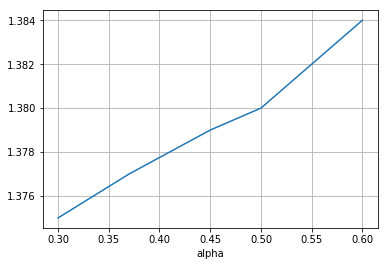

In [6]:
alphas = [0.3, 0.37, 0.45, 0.5, 0.6]
scores = [1.375, 1.377, 1.379, 1.380, 1.384]
plt.figure()
plt.plot(alphas, scores)
plt.xlabel('alpha')
plt.ylabel('')
plt.grid()
plt.show()

In [56]:
mean_boosters = (prediction_lgb2_eli5_uncorr_top + prediction_xgb2_eli5_uncorr_top) / 2
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = (mean_boosters + prediction_magic) / 2
submission.to_csv('../output/submission_magic_xgb2_lgb2_eli5_top_uncorr_v2.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.01148625682906079
seg_0012b5,5.13891331804562057
seg_00184e,5.32312523062705800
seg_003339,8.67235613429044250
seg_0042cc,7.08505345142917164


### RFE (Feature ranking with recursive feature elimination)

In [57]:
recompute_rfe_analysis = False

In [58]:
if recompute_rfe_analysis:
    scores_dict = {'rfe_score': [], 'n_features': []}
    total_num_features = X_train_scaled_uncorr.shape[1]
    rfe_feat = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 20, 30, 40, 50,
                110, 150, 210, 250, 310, 350, 410, 510,
                610, 710, 810, 850, 910, 950, 1010, 1113]
    for i in tqdm_notebook(rfe_feat):
        model = lgb.LGBMRegressor(**params_lgb_uncorr, n_estimators = 50000, n_jobs = -1, verbose=-1)
        s1 = RFE(model, i, step=100)
        #s1 = SelectPercentile(f_classif, percentile=i)
        #s2 = SelectPercentile(mutual_info_classif, percentile=i)
        #s1 = SelectKBest(f_classif, k=i)
        X_train1 = s1.fit_transform(X_train_scaled_uncorr, y_tr.values.astype(int))
        X_test1 = s1.transform(X_test_scaled_uncorr)    
        oof, prediction, scores = train_model(X=X_train1,
                                              X_test=X_test1,
                                              y=y_tr.values.reshape(-1, ),
                                              params=params_lgb_uncorr,
                                              folds=folds_models,
                                              model_type='lgb',
                                              compute_feature_importance=False)
        scores_dict['rfe_score'].append(np.mean(scores))    
        scores_dict['n_features'].append(X_train1.shape[1])
        scores_df = pd.DataFrame(scores_dict)
        scores_df.to_csv(f'../tmp_results/rfe_scores.csv', index=False)
else:
    scores_df = pd.read_csv(f'../tmp_results/rfe_scores.csv')

In [59]:
#scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['rfe_score'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.01
min_value = scores_df['mae'].min() * 0.99
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:Q',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by RFE vs CV'
).interactive())

In [60]:
params_lgb_rfe_uncorr_top = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': BAGGING_SEED,
    'random_seed': GLOBAL_SEED,
    'metric': 'mae',
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}
top_num_features = 150
model = lgb.LGBMRegressor(**params_lgb_rfe_uncorr_top, n_estimators = 50000, n_jobs = -1, verbose=-1)
s1 = RFE(model, top_num_features, step=100)
X_train1 = s1.fit_transform(X_train_scaled_uncorr, y_tr.values.astype(int))
X_test1 = s1.transform(X_test_scaled_uncorr)

Fold 0 started at Sat Jun  1 17:25:49 2019
Fold 1 started at Sat Jun  1 17:25:55 2019
Fold 2 started at Sat Jun  1 17:25:59 2019
Fold 3 started at Sat Jun  1 17:26:02 2019
Fold 4 started at Sat Jun  1 17:26:06 2019
CV mean score: 2.0014, std: 0.0405.


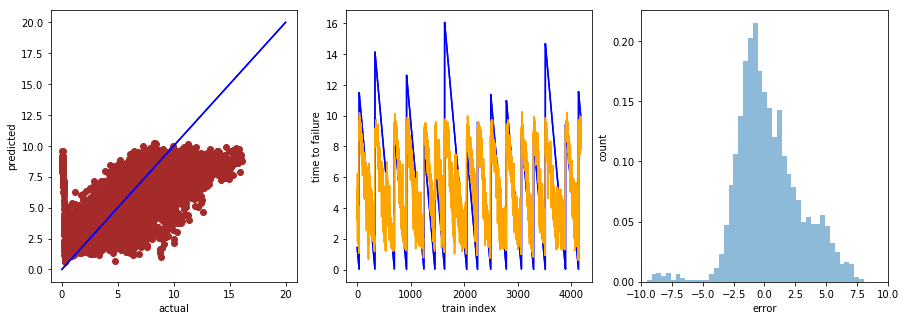

In [103]:
oof_lgb_rfe_uncorr_top, prediction_lgb_rfe_uncorr_top, scores_lgb_rfe_uncorr_top = train_model(
    X=X_train1,
    X_test=X_test1,
    y=y_tr.values.reshape(-1, ),
    params=params_lgb_rfe_uncorr_top,
    folds=folds_models,
    model_type='lgb',
    compute_feature_importance=False,
    show_scatter=True)

It seems that a sligh modification on the objective function may yield important gains. The idea is that using sqrt(```time_to_failure```) and using MSE gives much better performance on MAE once squaring the predictions. 
https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/92440

## Model compatison

LGB-opt not computed
LGB_uncorr-opt not computed
LGB_eli5_top-opt not computed
LGB_eli5_uncorr_top-opt not computed


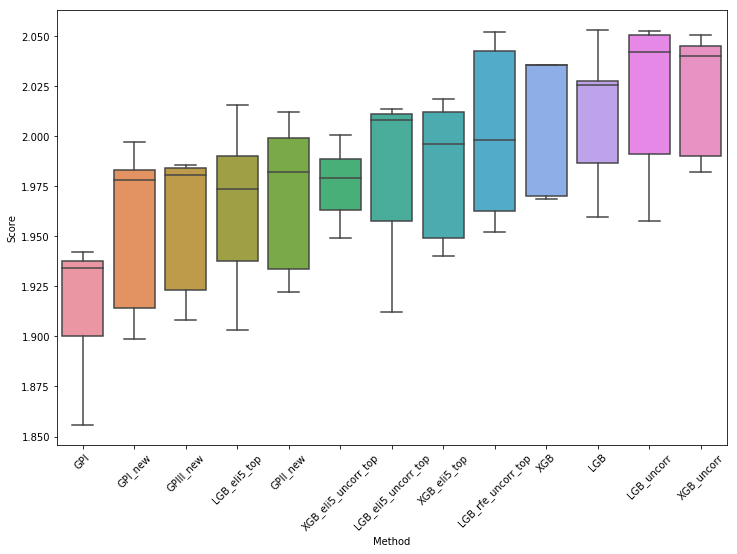

In [19]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame()

try:
    scores_df['LGB'] = scores_lgb
except NameError:
    print('LGB not computed')
try:
    scores_df['LGB-opt'] = scores_lgb_opt
except NameError:
    print('LGB-opt not computed')
try:
    scores_df['LGB_uncorr'] = scores_lgb_uncorr
except NameError:
    print('LGB_uncorr not computed')
try:
    scores_df['LGB_uncorr-opt'] = scores_lgb_uncorr_opt
except NameError:
    print('LGB_uncorr-opt not computed')
try:
    scores_df['LGB_eli5_top'] = scores_lgb_eli5_top
except NameError:
    print('LGB_eli5_top not computed')
try:
    scores_df['LGB_eli5_top-opt'] = scores_lgb_eli5_top_opt
except NameError:
    print('LGB_eli5_top-opt not computed')
try:
    scores_df['LGB_eli5_uncorr_top'] = scores_lgb_eli5_uncorr_top
except NameError:
    print('LGB_eli5_uncorr_top not computed')
try:
    scores_df['LGB_eli5_uncorr_top-opt'] = scores_lgb_eli5_uncorr_top_opt
except NameError:
    print('LGB_eli5_uncorr_top-opt not computed')
try:
    scores_df['LGB_rfe_uncorr_top'] = scores_lgb_rfe_uncorr_top
except NameError:
    print('LGB_rfe_uncorr_top not computed')    
try:
    scores_df['XGB'] = scores_xgb
except NameError:
    print('XGB not computed')
try:
    scores_df['XGB_uncorr'] = scores_xgb_uncorr
except NameError:
    print('XGB_uncorr not computed')    
try:
    scores_df['XGB_eli5_top'] = scores_xgb_eli5_top
except NameError:
    print('XGB_eli5_top not computed')
try:
    scores_df['XGB_eli5_uncorr_top'] = scores_xgb_eli5_uncorr_top
except NameError:
    print('XGB_eli5_uncorr_top not computed')
try:
    scores_df['GPI'] = scores_gpi
except NameError:
    print('GPI not computed')
try:
    scores_df['GPI_new'] = scores_gpi_new
except NameError:
    print('GPI_new not computed')
try:
    scores_df['GPII_new'] = scores_gpii_new
except NameError:
    print('GPII_new not computed')    
try:
    scores_df['GPIII_new'] = scores_gpiii_new
except NameError:
    print('GPIII_new not computed')
    
ax = sns.boxplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1));
#ax.set(yscale="log")

plt.xticks(rotation=45);
plt.xlabel('Method');
plt.ylabel('Score');

## Preparing the submission

### Risky model (LB: 1.375)
This is the model that has given the best score on the LB. There is a high likelihood that it has overfitted the public testing set. The model is a blending of the following models:
- Prediction from [this public Kernel](https://www.kaggle.com/zikazika/how-to-score-high).
- XGBoost model using a selection of 150 uncorrelated features and trained using RMSE isntead of MAE.

In [72]:
alpha = 0.45
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = (1 - alpha) * prediction_xgb2_eli5_uncorr_top
                                + alpha * prediction_magic
submission.to_csv('../output/final_submission_risky.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.92895826111315394
seg_0012b5,5.10023926753457602
seg_00184e,5.23975877217968211
seg_003339,8.69751633336114871
seg_0042cc,6.99245020883070723


### Conservative model (LB: 1.445)
This is a model formed by blending multiple methods that have given a good mean CV score.
- LSTM neural network with 5 folds (trained of 5 different seeds).
- Genetic Programming predictor based on features. It was obtained from [this public kernel](https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model).
- LightGBM model using the 150 top features.
- XGBoost model using 150 uncorrelated features.

In [22]:
prediction_blended = (prediction_lstm_5fold
                      + prediction_gpi
                      + prediction_lgb_eli5_top
                      + prediction_xgb_eli5_uncorr_top) / 4

In [23]:
evaluation = pd.DataFrame(dtype=np.float64)
submission['time_to_failure'] = prediction_blended
submission.to_csv('../output/final_submission_conservative.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.99451458094059442
seg_0012b5,5.32606369200845187
seg_00184e,5.21348880742764109
seg_003339,8.35128439733411732
seg_0042cc,6.88975535396278449
